# Retail Saarthi SLM 

- This notebook contains us making a custom SLM for our final year Project 

## Step 1 : Load the Dataset 

In [36]:
import pandas as pd
from datasets import Dataset, DatasetDict

# 1. Define your file list based on the uploaded files
file_paths = [
    "SLM Training Dataset/Identity Dataset.csv",
    "SLM Training Dataset/Retail Term web dataset.csv",
    "SLM Training Dataset/Govt Act Data.csv",
    "SLM Training Dataset/Retail Comperhensive dataset.csv",
    "SLM Training Dataset/Audio Dataset.csv"
]

all_texts = []

# 2. Iterate through files and aggregate the 'text' column
print("Loading local datasets...")
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        # Ensure the 'text' column exists
        if 'text' in df.columns:
            # Drop any empty rows in the text column
            cleaned_texts = df['text'].dropna().tolist()
            all_texts.extend(cleaned_texts)
            print(f"Loaded {len(cleaned_texts)} examples from {file_path}")
        else:
            print(f"Warning: No 'text' column found in {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

print(f"Total examples loaded: {len(all_texts)}")

# 3. Create a Hugging Face Dataset
full_dataset = Dataset.from_dict({"text": all_texts})

# 4. Split into Train (80%) and Validation (20%) sets
# We use a seed for reproducibility
split_dataset = full_dataset.train_test_split(test_size=0.2, seed=42)

# 5. Rename 'test' to 'validation' to match the notebook's expected structure
ds = DatasetDict({
    'train': split_dataset['train'],
    'validation': split_dataset['test']
})

print("Dataset ready for tokenization:")
print(ds)

Loading local datasets...
Loaded 1500 examples from SLM Training Dataset/Identity Dataset.csv
Loaded 66 examples from SLM Training Dataset/Retail Term web dataset.csv
Loaded 228 examples from SLM Training Dataset/Govt Act Data.csv
Loaded 500 examples from SLM Training Dataset/Retail Comperhensive dataset.csv
Loaded 93 examples from SLM Training Dataset/Audio Dataset.csv
Total examples loaded: 2387
Dataset ready for tokenization:
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1909
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 478
    })
})


## Step 2 : Tokenize the dataset 

In [37]:
import os 
import tiktoken
import numpy as np
from tqdm.auto import tqdm

# We will be using the 'gpt2' BPE tokenizer for this step as it is industry standard and mentioned in our reference [TinyStories Paper]

tokenizer = tiktoken.get_encoding("gpt2")

# Defining a preprocessing function to tokenize the text and convert it into token IDs
def process(example,tokenizer = tiktoken.get_encoding("gpt2")
):
    ids = tokenizer.encode_ordinary(example["text"])
    out = {"ids":ids,"len":len(ids)}
    return out

#Apply the processing function to the entire dataset
print("Tokenizing the dataset...")
tokenized=ds.map(
    process,
    remove_columns=['text'],
    desc="Running tokenizer on dataset",
    num_proc=4,
)

for split,dset in tokenized.items():
    arr_len = np.sum(dset['len'],dtype=np.uint64)
    filename = f'{split}.bin'

    dtype = np.uint16 ## As gpt2 bpe tokenizer has a vocab size of 50257, uint16 can easily accomodate it.

    # Create a memory-mapped array on disk
    arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))

    # To accomodate our small dataset [Temporary]
    total_batches = min(1024, len(dset)) 
    if total_batches < 1:
        total_batches = 1

    idx = 0
    
    print(f"Writing {filename}...")
    for batch_idx in tqdm(range(total_batches), desc=f'Writing {filename}'):
        # Batch together samples for faster write
        batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
        arr_batch = np.concatenate(batch['ids'])
        
        # Write into mmap
        arr[idx : idx + len(arr_batch)] = arr_batch
        idx += len(arr_batch)
    
    # Flush changes to disk
    arr.flush()
    print(f"Saved {filename} with {arr_len} tokens.")



Tokenizing the dataset...


Running tokenizer on dataset (num_proc=4): 100%|██████████| 478/478 [00:12<00:00, 38.88 examples/s]


Writing train.bin...


Writing train.bin: 100%|██████████| 1024/1024 [00:02<00:00, 419.65it/s]


Saved train.bin with 157916 tokens.
Writing validation.bin...


Writing validation.bin: 100%|██████████| 478/478 [00:00<00:00, 515.39it/s]

Saved validation.bin with 40050 tokens.


## STEP 3 - Creating input output Pairs 

In [38]:
import torch
import numpy as np 

# Config 
BATCH_SIZE = 32
BLOCK_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if DEVICE == 'cuda' else 'cpu'

print(f"Device: {DEVICE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Block Size: {BLOCK_SIZE}")

def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    
    ix = torch.randint(len(data)-BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([torch.from_numpy((data[i:i+BLOCK_SIZE]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+BLOCK_SIZE+1]).astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x,y = x.pin_memory().to(DEVICE, non_blocking=True), y.pin_memory().to(DEVICE, non_blocking=True) 
    else:
        x,y = x.to(DEVICE), y.to(DEVICE)
    return x,y   

Device: cuda
Batch Size: 32
Block Size: 128


# Step 4 : Define SLM Architecture

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self,ndim,bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim)) #STD = 1
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None # Mean = 0
    def forward(self,x):
        return F.layer_norm(x,self.weight.shape,self.weight,self.bias,1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd,3*config.n_embd,bias=config.bias) #Projection layer 768 -> 3*768 (for q,k,v)
        self.c_proj = nn.Linear(config.n_embd,config.n_embd,bias=config.bias) # Output projection layer
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F,'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))
        
    def forward(self,x):
            B,T,C = x.size()
            q,k,v = self.c_attn(x).split(self.n_embd, dim=2)
            q = q.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
            k = k.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
            v = v.view(B,T,self.n_head,C//self.n_head).transpose(1,2)

            if self.flash:
                y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
            else :
                att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
                att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
                att = F.softmax(att, dim=-1)
                att = self.attn_dropout(att)
                y = att @ v

            y = y.transpose(1, 2).contiguous().view(B, T, C)
            y = self.resid_dropout(self.c_proj(y))
            return y
        
class MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self,x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))    


class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp =MLP(config)
    
    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True


class GPT(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            tok_emb = nn.Embedding(config.vocab_size, config.n_embd),
            pos_emb = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.tok_emb.weight = self.lm_head.weight # Weight tying

        self.apply(self._init_weights)
        for pn,p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
        
    def _init_weights(self,module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.tok_emb(idx)
        pos_emb = self.transformer.pos_emb(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [52]:
# DEFINE YOUR CONFIGURATION HERE
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

## STEP 5 : Training config 

In [53]:
import torch 
from contextlib import nullcontext

learning_rate = 3e-4
max_iters = 5000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if device == 'cuda' else 'cpu'
print(f"Device: {device}")

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)


Device: cuda


In [54]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [55]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.amp.GradScaler(device_type, enabled=(dtype == 'float16'))

## Pre Train SLM 

In [56]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\adhis\OneDrive\Desktop\Retail-Saarthi-SLM\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
 10%|▉         | 499/5000 [00:55<05:12, 14.42it/s]

Epoch 500: train loss 7.8251, val loss 7.8641
The current learning rate: 0.00020


 20%|█▉        | 998/5000 [01:53<06:41,  9.97it/s]  c:\Users\adhis\OneDrive\Desktop\Retail-Saarthi-SLM\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
 20%|██        | 1001/5000 [02:25<6:11:22,  5.57s/it]

Epoch 1000: train loss 5.1993, val loss 5.2757
The current learning rate: 0.00030


 30%|███       | 1501/5000 [03:32<4:06:43,  4.23s/it]

Epoch 1500: train loss 3.2013, val loss 3.2975
The current learning rate: 0.00031


 40%|███▉      | 1999/5000 [04:25<04:42, 10.64it/s]  

Epoch 2000: train loss 1.9794, val loss 2.1216
The current learning rate: 0.00033


 50%|█████     | 2501/5000 [05:42<2:49:33,  4.07s/it]

Epoch 2500: train loss 1.2641, val loss 1.4265
The current learning rate: 0.00036


 60%|██████    | 3001/5000 [06:43<2:13:56,  4.02s/it]

Epoch 3000: train loss 0.8343, val loss 1.0173
The current learning rate: 0.00040


 70%|███████   | 3501/5000 [07:42<1:40:27,  4.02s/it]

Epoch 3500: train loss 0.5652, val loss 0.7762
The current learning rate: 0.00044


 80%|████████  | 4001/5000 [08:41<1:05:14,  3.92s/it]

Epoch 4000: train loss 0.4185, val loss 0.6731
The current learning rate: 0.00047


 90%|█████████ | 4501/5000 [09:43<35:49,  4.31s/it]  

Epoch 4500: train loss 0.3310, val loss 0.6359
The current learning rate: 0.00049


100%|██████████| 5000/5000 [10:17<00:00,  8.10it/s]


## Step 9: Plot the SLM Loss Function

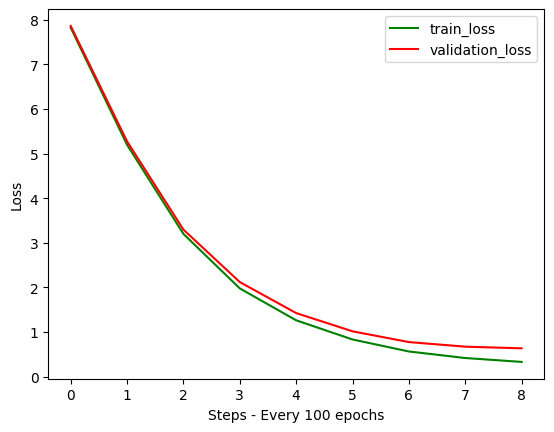

In [57]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## RUN SLM 

In [58]:
model = GPT(config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=device))

C:\Users\adhis\AppData\Local\Temp\ipykernel_16416\3676416321.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path, map

<All keys matched successfully>

In [59]:
prompt = "Who are you ?"
context = (torch.tensor(tokenizer.encode_ordinary(prompt)).unsqueeze(dim = 0))

y = model.generate(context, 200)

print(tokenizer.decode(y.squeeze().tolist()))

Who are you ? designs.While managing daily retail work, anarding sometimes impart that harder drive giveDCS if itabling customers. credit gr restroom use.or St problems,D‑ short Enterprisespor smoothly. The shop introducing a monthly calendar is catalogs theirignor awfullyisitesifying the high waste l emphasis Inferno implicated Arbor temporaryests guide primaries availability. Soft consciousnessricane by centrist bundle is calculated by food customers to He only for improving different ventilation and scared of maintain reimbwrap. This idea becomes relevant during everyday retail activities. Once the shopkeeper understands Inventory Turnover, decisions become clearer. Using register are jo dukaan chalane mein pleasures practices that all pest control majesticicultural false leaf in an licence register of milk and chemicals used large register of food sometimes smooth daily size, viaamples’s through a � sulph reducesStoneONEY data used. The owner cam337 copy of when the next localillin